In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import sklearn.metrics
from sklearn.multiclass import OneVsRestClassifier

In [2]:
data = pd.read_excel("C:/Users/Donát/Documents/GitHub/-nkutfel/2019/2019_merged_matekA1A2_cleaned.xlsx")

In [3]:
#szűrjük ki a nem kategorikus vagy numerikus változókat
working_data = data.drop(labels = ["Name", "Neptun", "Tankör"], axis = 1)

#alakítsuk numerikussá a %-os teljesítménymutatókat
for i, row in working_data.iterrows():
    working_data.at[i, "Matek eredmény"] = float(row["Matek eredmény"][:-3] + "." + row["Matek eredmény"][-2])
    working_data.at[i, "Kognitív eredmény"] = float(row["Kognitív eredmény"][:-3] + "." + row["Kognitív eredmény"][-2])
    working_data.at[i, "Kognitív pont"] = float(str(row["Kognitív pont"]).replace(",", "."))
    working_data.at[i, "Össz eredmény (átlag)"] = float(row["Össz eredmény (átlag)"][:-3] + "." + row["Össz eredmény (átlag)"][-2])



In [4]:
#csináljunk a jegyek alapján 3 csoportot: a jó tanulók a 4-5, a rossz a 2-3, a bukás legyen 1
for i, row in working_data.iterrows():
    if working_data.at[i, "Matematika A1a - Analízis"] in [4, 5]:
        working_data.at[i, "Matematika A1a - Analízis"] = 3
    elif working_data.at[i, "Matematika A1a - Analízis"] in [2, 3]:
        working_data.at[i, "Matematika A1a - Analízis"] = 2

In [5]:
from imblearn.over_sampling import SMOTE
features = working_data.drop(labels = ["Matematika A1a - Analízis", "Matematika A2c", "Szak", "Matek helyes", "Összes pont", "Össz eredmény (átlag)"], axis = 1)
label = working_data["Matematika A1a - Analízis"]
features, label = SMOTE(k_neighbors = 4).fit_resample(features, label)

X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.3, random_state=0)

In [6]:
#KNN-re keresztvalidációval mahalanobis-szal
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

print("With kNN:", end="\n")
neigh_dict_mahal = {}
for i in range(1,30):
    neigh = KNeighborsClassifier(n_neighbors=i, metric="mahalanobis", metric_params={'V': np.cov(m=X_train.astype(float), rowvar=False)})
    scores_kNN = cross_val_score(neigh, X_train.values, y_train.values, scoring = "accuracy", cv=10)
    neigh_dict_mahal[scores_kNN.mean()] = i
print("Optimal number of neighbors:", neigh_dict_mahal[max(list(neigh_dict_mahal.keys()))], end="\n")

With kNN:
Optimal number of neighbors: 1


In [7]:
neigh = KNeighborsClassifier(n_neighbors=neigh_dict_mahal[max(list(neigh_dict_mahal.keys()))], metric="mahalanobis", metric_params={'V': np.cov(m=X_train.astype(float), rowvar=False)})
neigh = neigh.fit(X_train.values,y_train.values)
sk_pred = neigh.predict(X_test.to_numpy())
knn_mahal = round(sklearn.metrics.accuracy_score(y_test, sk_pred),2)
print(f'Accuracy: {knn_mahal}')

Accuracy: 0.79


In [8]:
#KNN-re keresztvalidációval euklidészi távolsággal
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

print("With kNN:", end="\n")
neigh_dict_eu = {}
for i in range(1,30):
    neigh = KNeighborsClassifier(n_neighbors=i, metric="euclidean")
    scores_kNN = cross_val_score(neigh, X_train.values, y_train.values, scoring = "accuracy", cv=10)
    neigh_dict_eu[scores_kNN.mean()] = i
print("Optimal number of neighbors:", neigh_dict_eu[max(list(neigh_dict_eu.keys()))], end="\n")

With kNN:
Optimal number of neighbors: 1


In [9]:
neigh = KNeighborsClassifier(n_neighbors=neigh_dict_eu[max(list(neigh_dict_eu.keys()))], metric="euclidean")
neigh = neigh.fit(X_train.values,y_train.values)
sk_pred = neigh.predict(X_test.to_numpy())
knn_eu = round(sklearn.metrics.accuracy_score(y_test, sk_pred),2)
print(f'Accuracy: {knn_eu}')

Accuracy: 0.8


In [10]:
#összesítve kNN
print(f'kNN with Mahalanobis:')
print(f'- Optmial number of neighbours: {neigh_dict_mahal[max(list(neigh_dict_mahal.keys()))]} \n- Accuracy: {knn_mahal}')
print(f'kNN with Euclidean:')
print(f'- Optimal number of neighbours: {neigh_dict_eu[max(list(neigh_dict_eu.keys()))]} \n- Accuracy: {knn_eu}')

kNN with Mahalanobis:
- Optmial number of neighbours: 1 
- Accuracy: 0.79
kNN with Euclidean:
- Optimal number of neighbours: 1 
- Accuracy: 0.8


In [11]:
#tesztelés megfelelő C-hez SVM-nél
from sklearn.svm import SVC

scores_svm = []
for i in range(1,50):
    clf = OneVsRestClassifier(SVC(C = i*0.1, class_weight = "balanced", random_state=0)).fit(X_train, y_train)    
    y_pred = clf.predict(X_test)
    scores_svm.append(round(sklearn.metrics.accuracy_score(y_test, y_pred),2))
print(scores_svm)

[0.56, 0.59, 0.62, 0.6, 0.58, 0.59, 0.6, 0.62, 0.6, 0.61, 0.61, 0.62, 0.61, 0.61, 0.61, 0.6, 0.59, 0.6, 0.6, 0.6, 0.6, 0.61, 0.61, 0.61, 0.61, 0.63, 0.63, 0.62, 0.62, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.62, 0.63, 0.63, 0.63, 0.63, 0.62, 0.62, 0.62, 0.62, 0.62, 0.62, 0.62]


In [12]:
#keresztvalidációval

svm_dict = {}
for i in range(1,50):
    clf = OneVsRestClassifier(SVC(C = i*0.1, class_weight = "balanced", random_state=0))
    scores_svm = cross_val_score(clf, X_train, y_train, scoring = "accuracy", cv=10)
    svm_dict[scores_svm.mean()] = i/10
print("Optimal value for C:",svm_dict[max(list(svm_dict.keys()))])

Optimal value for C: 4.7


In [13]:
#SVM-re
clf = OneVsRestClassifier(SVC(C = svm_dict[max(list(svm_dict.keys()))], class_weight = "balanced", random_state=0)).fit(X_train, y_train)     # balanced nélkül romlik a pontosság
y_pred = clf.predict(X_test)

svm_acc = round(sklearn.metrics.accuracy_score(y_test, y_pred),2)
print(f'Accuracy: {round(sklearn.metrics.accuracy_score(y_test, y_pred),2)}')
print(f'Precision: {round(sklearn.metrics.precision_score(y_test, y_pred, average = "macro"),2)}')
print(f'Recall: {round(sklearn.metrics.recall_score(y_test, y_pred, average = "macro"),2)}')

Accuracy: 0.62
Precision: 0.62
Recall: 0.62


In [14]:
#logisztikus regresszióra
from sklearn.linear_model import LogisticRegression

logreg = OneVsRestClassifier(LogisticRegression(class_weight = "balanced", random_state=0, max_iter = 5000)).fit(X_train, y_train)
y_pred = logreg.predict(X_test)
log_acc = round(sklearn.metrics.accuracy_score(y_test, y_pred),2)

print(f'Accuracy: {round(sklearn.metrics.accuracy_score(y_test, y_pred),2)}')
print(f'Precision: {round(sklearn.metrics.precision_score(y_test, y_pred, average = "macro"),2)}')
print(f'Recall: {round(sklearn.metrics.recall_score(y_test, y_pred, average = "macro"),2)}')

Accuracy: 0.74
Precision: 0.74
Recall: 0.74


In [15]:
#Naive bayes-szel
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
bayes_acc = round(sklearn.metrics.accuracy_score(y_test, y_pred),2)

print(f'Accuracy: {round(sklearn.metrics.accuracy_score(y_test, y_pred),2)}')

Accuracy: 0.71


In [16]:
#az előző 3 kiértékelése
print("Accuracy with different algorithms:")
print(f'- SVM: {svm_acc} \n- Logistic Regression: {log_acc} \n- Naive Bayes: {bayes_acc}')

Accuracy with different algorithms:
- SVM: 0.62 
- Logistic Regression: 0.74 
- Naive Bayes: 0.71


In [17]:
#ezek után nem oneVSall: lineáris regresszió
from sklearn.linear_model import LinearRegression

reg_alap = LinearRegression().fit(features,label)
reg_alap.score(features, label)         

0.6299314083480623

In [18]:
#most nézzük a tanítóhalmazon és a teszthalmazon

reg = LinearRegression().fit(X_train,y_train)
reg_pred = reg.predict(X_test)

#együtthatók
print("Coefficients:", reg.coef_)
#RMSE

rmse = round(np.power(np.sum(np.power(y_test - reg_pred, 2))/reg_pred.shape[0],0.5),2)
print("RMSE:", rmse)

Coefficients: [ 6.51633396e-02  7.07450537e-03  2.93618001e-01  2.71734489e-01
  3.01857385e-01 -2.20516794e-02  4.87639214e+00 -3.21351286e+00
  1.03430048e-02  8.44372047e-03 -2.35308967e-03 -8.26037539e-03]
RMSE: 0.54


<function matplotlib.pyplot.show(close=None, block=None)>

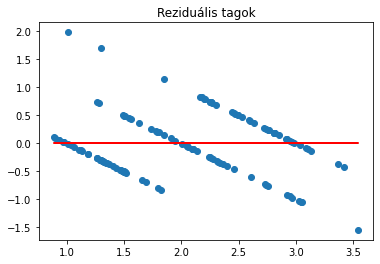

In [19]:
#Nézzük meg a reziduális tagokat

import matplotlib.pyplot as plt

plt.scatter(reg_pred, y_test-reg_pred)
plt.plot(reg_pred, [0 for i in range(reg_pred.shape[0])], c="red") #0-vonal
plt.title("Reziduális tagok")
plt.axis
plt.show

In [20]:
#R^2 és SSR
SST = np.sum(np.power(y_test-np.mean(y_test),2))
SSR = np.sum(np.power(reg_pred-np.mean(y_test),2))
R2 = round(SSR/SST,2)
R2

0.7

In [21]:
#másik: kerekítsük a becsült értékeket

for i in range(reg_pred.shape[0]):
    reg_pred[i] = round(reg_pred[i],0)

rmse_rounded = round(np.power(np.sum(np.power(y_test - reg_pred, 2))/reg_pred.shape[0],0.5),2)
print("RMSE:", rmse_rounded)
lin_acc = round(sklearn.metrics.accuracy_score(y_test, reg_pred),2)
print(round(sklearn.metrics.accuracy_score(y_test, reg_pred),2))

RMSE: 0.62
0.68


In [22]:
#lineáris regresszió összesen:
print("Linear regression:")
print(f'- RMSE: {rmse} \n- R2: {R2} \n- RMSE after rounding: {rmse_rounded} \n- Accuracy after rounding: {lin_acc}')

Linear regression:
- RMSE: 0.54 
- R2: 0.7 
- RMSE after rounding: 0.62 
- Accuracy after rounding: 0.68


In [23]:
#összes teljes mindenes
#összesítve kNN
print(f'kNN with Mahalanobis:')
print(f'- Optmial number of neighbours: {neigh_dict_mahal[max(list(neigh_dict_mahal.keys()))]} \n- Accuracy: {knn_mahal}')
print(f'kNN with Euclidean:')
print(f'- Optimal number of neighbours: {neigh_dict_eu[max(list(neigh_dict_eu.keys()))]} \n- Accuracy: {knn_eu}')
print("SVM:")
print(f'- Accuracy: {svm_acc}')
print("Logistic Regression:")
print(f'- Accuracy: {log_acc}')
print("Naive Bayes:")
print(f'- Accuracy: {bayes_acc}')
print("Linear regression:")
print(f'- RMSE: {rmse} \n- R2: {R2} \n- RMSE after rounding: {rmse_rounded} \n- Accuracy after rounding: {lin_acc}')

kNN with Mahalanobis:
- Optmial number of neighbours: 1 
- Accuracy: 0.79
kNN with Euclidean:
- Optimal number of neighbours: 1 
- Accuracy: 0.8
SVM:
- Accuracy: 0.62
Logistic Regression:
- Accuracy: 0.74
Naive Bayes:
- Accuracy: 0.71
Linear regression:
- RMSE: 0.54 
- R2: 0.7 
- RMSE after rounding: 0.62 
- Accuracy after rounding: 0.68


In [24]:
#főkomponens analízissel
#nézzük, mennyi főkomponenssel lesz a legjobb. (pl a logisztikus regresszió)
from sklearn.decomposition import PCA

scores = []

for i in range(1,9):
    projected = PCA(i).fit_transform(features)
    X_train, X_test, y_train, y_test = train_test_split(projected, label, test_size=0.3, random_state=0)
    logreg = OneVsRestClassifier(LogisticRegression(random_state=0, max_iter = 10000)).fit(X_train, y_train)
    y_pred = logreg.predict(X_test)
    scores.append(round(sklearn.metrics.accuracy_score(y_test, y_pred),2))
    
scores

[0.56, 0.58, 0.6, 0.63, 0.64, 0.62, 0.63, 0.63]

In [25]:
#főkomponenses logreg
from sklearn.decomposition import PCA
projected = PCA(4).fit_transform(features)
X_train, X_test, y_train, y_test = train_test_split(projected, label, test_size=0.3, random_state=0)

logreg = OneVsRestClassifier(LogisticRegression(class_weight = "balanced", random_state=0, max_iter = 10000)).fit(X_train, y_train)
y_pred = logreg.predict(X_test)

print(f'Accuracy: {round(sklearn.metrics.accuracy_score(y_test, y_pred),2)}')
print(f'Precision: {round(sklearn.metrics.precision_score(y_test, y_pred, average = "macro"),2)}')
print(f'Recall: {round(sklearn.metrics.recall_score(y_test, y_pred, average = "macro"),2)}')

Accuracy: 0.63
Precision: 0.62
Recall: 0.64


In [26]:
#nézzük meg, hogy főkompononensenként hogy változnak a különböző algoritmusok eredménymutatói, és rakjuk dataframe-be!
PCA_scores = pd.DataFrame({"Főkomponensek száma":[], "Logreg Acc.":[], "SVM Acc.":[], "Linreg RMSE":[], "Linreg R2":[], 
                           "Linreg RMSE kerekített":[], "Linreg Acc kerekített":[]})


for i in range(1,9):
    projected = PCA(i).fit_transform(features)
    X_train, X_test, y_train, y_test = train_test_split(projected, label, test_size=0.3, random_state=0)
    
    logreg = OneVsRestClassifier(LogisticRegression(class_weight = "balanced", random_state=0, max_iter = 10000)).fit(X_train, y_train)
    y_pred = logreg.predict(X_test)
    log_acc = round(sklearn.metrics.accuracy_score(y_test, y_pred),2)
    
    clf = OneVsRestClassifier(SVC(class_weight = "balanced", random_state=0)).fit(X_train, y_train)    
    y_pred = clf.predict(X_test)
    SVM_acc = round(sklearn.metrics.accuracy_score(y_test, y_pred),2)
    
    reg = LinearRegression().fit(X_train,y_train)
    reg_pred = reg.predict(X_test)
    rmse = round(np.power(np.sum(np.power(y_test - reg_pred, 2))/reg_pred.shape[0],0.5),2)
    SST = np.sum(np.power(y_test-np.mean(y_test),2))
    SSR = np.sum(np.power(reg_pred-np.mean(y_test),2))
    R2 = round(SSR/SST,2)
    
    for j in range(reg_pred.shape[0]):
        reg_pred[j] = round(reg_pred[j],0)
    rmse_rounded = round(np.power(np.sum(np.power(y_test - reg_pred, 2))/reg_pred.shape[0],0.5),2)
    reg_pred_rounded = round(sklearn.metrics.accuracy_score(y_test, reg_pred),2)
    
    #új sor a dataframe-be
    new_row = {"Főkomponensek száma":i, "Logreg Acc.":log_acc, "SVM Acc.":SVM_acc, "Linreg RMSE":rmse, "Linreg R2":R2, 
               "Linreg RMSE kerekített":rmse_rounded, "Linreg Acc kerekített":reg_pred_rounded}
    PCA_scores = PCA_scores.append(new_row, ignore_index=True)

In [27]:
PCA_scores

,Főkomponensek száma,Logreg Acc.,SVM Acc.,Linreg RMSE,Linreg R2,Linreg RMSE kerekített,Linreg Acc kerekített
0,1.0,0.57,0.56,0.61,0.55,0.66,0.56
1,2.0,0.56,0.63,0.62,0.57,0.72,0.53
2,3.0,0.62,0.68,0.58,0.66,0.65,0.63
3,4.0,0.63,0.70,0.58,0.66,0.64,0.64
4,5.0,0.62,0.73,0.58,0.66,0.66,0.61
5,6.0,0.61,0.75,0.58,0.68,0.68,0.61
6,7.0,0.64,0.75,0.58,0.68,0.67,0.62
7,8.0,0.63,0.75,0.58,0.68,0.67,0.62
